In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from validphys.loader import FallbackLoader as Loader
from validphys.api import API

In [2]:
# fit_names = [f"NNPDF40_nnlo_as_0{n}_corr_s{l}" for l in "12" for n in [1140,1150,1160,1170,1175,1180,1185,1190,1195,1200,1210,1220]]

#NOTE: 0.1990 was mistakenly done with theoryID 0.0120 instead
#fit_names = [f"240218-rs-nnpdf40-corr-mhou-0{n}" for n in range(1140,1220+1,10)]
# fit_names = [f"240219-rs-nnpdf40-corr-0{n}" for n in range(1140,1220+1,10)]
# Closure fit names (not iterated and no MHOU)

fit_names = [f"240301-ab-ct-alphas{n}-noMHOU" for n in range(114, 122+1, 1)]


In [3]:
l = Loader()
fits = [l.check_fit(f) for f in fit_names]

In [4]:
from collections import defaultdict
as_fits = defaultdict(list)
for f in fits:
    th = f.as_input()["theory"]["theoryid"]
    alpha = float(API.theory_info_table(theory_db_id = th).loc["alphas"])
    as_fits[alpha].append(f)
as_fits = dict(as_fits)

In [12]:
indexes = {f: API.fitted_replica_indexes(pdf=f.name) for f in fits}
replica_data = {f: API.replica_data(fit=f.name) for f in fits}

In [13]:
aa = []
for i in indexes.values():
    aa.append(i)


In [14]:
def measure(replica_data):
    return replica_data.training*3 + replica_data.validation*1
    # return replica_data.chi2

In [15]:
min_values = {}
for alpha, flist in as_fits.items():
    series = []
    for f in flist:
        s = [measure(d) for d in replica_data[f]]
        series.append(pd.Series(s, index=indexes[f]))
    min_values[alpha] = pd.DataFrame(series).min()
data = pd.DataFrame(min_values)

In [16]:
mins = {}
for ind, row in data.iterrows():
    a, b, c = np.polyfit(data.columns, row, 2)
    if not np.isnan(b): # NaN if not all replicas passed postfit
        mins[ind] = -b / 2 / a
    # mins[ind] = data.columns[np.where(row==row.min())][0]

mins = pd.Series(mins)

In [17]:
print(mins.describe(percentiles=[0.16,0.84]))
print("")
print(f"cv±std = {mins.mean():.5f} ± {mins.std():.5f} ")
print(f"1std interval:  {mins.mean()-mins.std():.5f} to {mins.mean()+mins.std():.5f} ")
print(f"68% c.i:        {mins.describe(percentiles=[0.16,0.84])[4]:.5f} to {mins.describe(percentiles=[0.16,0.84])[6]:.5f} ")

count    95.000000
mean      0.119571
std       0.000365
min       0.118729
16%       0.119179
50%       0.119559
84%       0.119999
max       0.120323
dtype: float64

cv±std = 0.11957 ± 0.00036 
1std interval:  0.11921 to 0.11994 
68% c.i:        0.11918 to 0.12000 


Text(0.5, 0, '$\\alpha_s$')

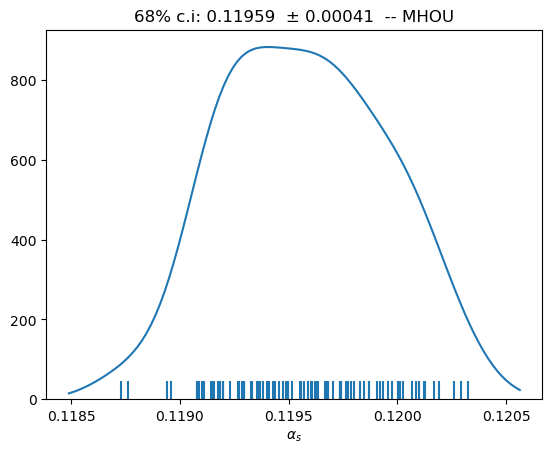

In [11]:
from validphys.plotutils import kde_plot
fig, ax = plt.subplots()
kde_plot(mins,ax=ax)
central = (mins.describe(percentiles=[0.16,0.84])[6] + mins.describe(percentiles=[0.16,0.84])[4])/2
unc = (mins.describe(percentiles=[0.16,0.84])[6] - mins.describe(percentiles=[0.16,0.84])[4])/2
ax.set_title(f"68% c.i: {central:.5f}  ± {unc:.5f}  -- MHOU")
#ax.set_xlim(0.118,0.13)
ax.set_xlabel(r"$\alpha_s$")

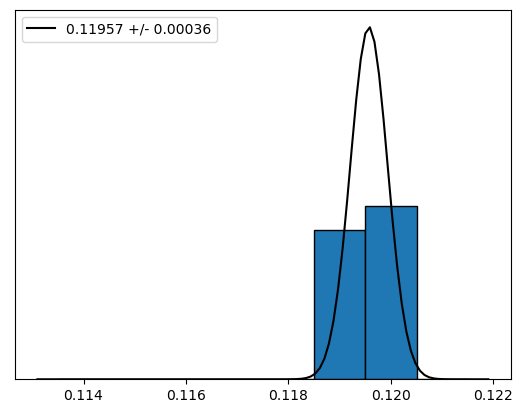

In [12]:
plt.hist(mins,bins=data.columns-0.0005,edgecolor='black',density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
from scipy.stats import norm
# p = np.exp(-((x-mins.mean())/mins.std())**2/2)*mins.size/np.sqrt(2*np.pi)
p = norm.pdf(x, mins.mean(), mins.std())
plt.plot(x,p,'k',label=f"{mins.mean():.5f} +/- {mins.std():.5f}")
plt.yticks([])
plt.legend()
plt.savefig('alphashist.pdf')

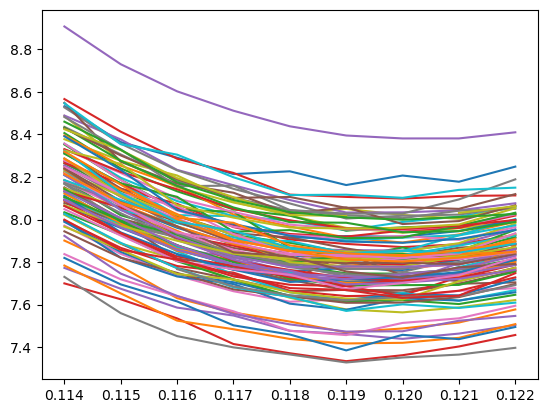

In [13]:
plt.plot(data.columns, np.array(data.T))

Here we try the experimental method for the closure test case

In [5]:
config_common = {"dataset_inputs":{"from_": "fit"}, "datacuts":{"from_":"fit"}, "use_cuts":{"from_": "datacuts"}, "fakepdf":{"from_":"closuretest"}, "theory":{"from_":"fit"}, "theoryid":{"from_":"theory"}, "pdf":{"from_": "fit"}, "closuretest":{"from_": "fit"}, "filterseed":{"from_":"closuretest"}, "use_fitcommondata": True, "use_t0": True, "t0pdfset":{"from_":"datacuts"} }

In [6]:
central_chi2 = {}
for alpha, flist in as_fits.items():
    config_common["fit"] = flist[0].name
    config_common["fits"] = [flist[0].name] #This is used only to load replica 1 data, and it currently needs a list of fits
    central_chi2[alpha] = API.central_chi2_level1(**config_common) #This function is only present in the branch closure_with_same_level1

LHAPDF 6.4.0 loading /Users/andrea/miniconda3/envs/nnpdf/share/LHAPDF/231223-ab-baseline-nnlo-global-NNLOcuts_iterated/231223-ab-baseline-nnlo-global-NNLOcuts_iterated_0000.dat
231223-ab-baseline-nnlo-global-NNLOcuts_iterated PDF set, member #0, version 1
LHAPDF 6.4.0 loading /Users/andrea/miniconda3/envs/nnpdf/share/LHAPDF/240301-ab-ct-alphas114-noMHOU/240301-ab-ct-alphas114-noMHOU_0000.dat
240301-ab-ct-alphas114-noMHOU PDF set, member #0, version 1
LHAPDF 6.4.0 loading /Users/andrea/miniconda3/envs/nnpdf/share/LHAPDF/240301-ab-ct-alphas115-noMHOU/240301-ab-ct-alphas115-noMHOU_0000.dat
240301-ab-ct-alphas115-noMHOU PDF set, member #0, version 1
LHAPDF 6.4.0 loading /Users/andrea/miniconda3/envs/nnpdf/share/LHAPDF/240301-ab-ct-alphas116-noMHOU/240301-ab-ct-alphas116-noMHOU_0000.dat
240301-ab-ct-alphas116-noMHOU PDF set, member #0, version 1
LHAPDF 6.4.0 loading /Users/andrea/miniconda3/envs/nnpdf/share/LHAPDF/240301-ab-ct-alphas117-noMHOU/240301-ab-ct-alphas117-noMHOU_0000.dat
240301-a

In [7]:
a, b, c = np.polyfit(list(central_chi2.keys()), list(central_chi2.values()), 2)
min_exp_meth = - b / 2 /a
NDATA = 4616
VARCHI2 = 1.0 / 4616 
uncer = np.sqrt(VARCHI2/a)
print(f"cv±std = {min_exp_meth:.5f} ± {uncer:.5f} ")

cv±std = 0.11913 ± 0.00029 


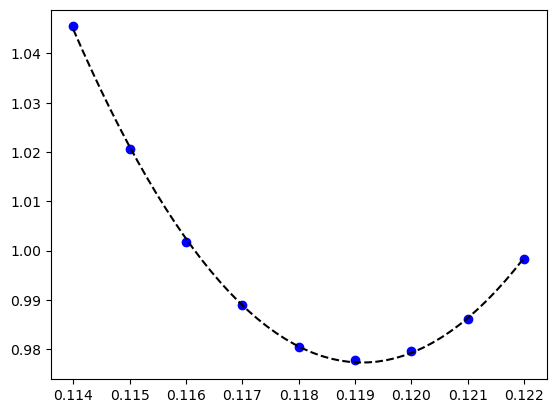

In [8]:
plt.scatter(list(central_chi2.keys()),list(central_chi2.values()), color="blue" )
plt.plot(np.linspace(0.114, 0.122), [a*x*x + b*x + c for x in np.linspace(0.114, 0.122)], color="black", linestyle="--")

In [9]:
central_chi2_replicas = {}
for alpha, flist in as_fits.items():
    config_common["fit"] = flist[0].name
    config_common["fits"] = [flist[0].name] #This is used only to load replica 1 data, and it currently needs a list of fits
    central_chi2_replicas[alpha] = np.mean(API.replica_chi2_level1(**config_common)) #This function is only present in the branch closure_with_same_level1

LHAPDF 6.4.0 loading all 101 PDFs in set 240301-ab-ct-alphas114-noMHOU
240301-ab-ct-alphas114-noMHOU, version 1; 101 PDF members
LHAPDF 6.4.0 loading all 101 PDFs in set 240301-ab-ct-alphas115-noMHOU
240301-ab-ct-alphas115-noMHOU, version 1; 101 PDF members
LHAPDF 6.4.0 loading all 101 PDFs in set 240301-ab-ct-alphas116-noMHOU
240301-ab-ct-alphas116-noMHOU, version 1; 101 PDF members
LHAPDF 6.4.0 loading all 101 PDFs in set 240301-ab-ct-alphas117-noMHOU
240301-ab-ct-alphas117-noMHOU, version 1; 101 PDF members
LHAPDF 6.4.0 loading all 101 PDFs in set 240301-ab-ct-alphas118-noMHOU
240301-ab-ct-alphas118-noMHOU, version 1; 101 PDF members
LHAPDF 6.4.0 loading all 101 PDFs in set 240301-ab-ct-alphas119-noMHOU
240301-ab-ct-alphas119-noMHOU, version 1; 101 PDF members
LHAPDF 6.4.0 loading all 101 PDFs in set 240301-ab-ct-alphas120-noMHOU
240301-ab-ct-alphas120-noMHOU, version 1; 101 PDF members
LHAPDF 6.4.0 loading all 101 PDFs in set 240301-ab-ct-alphas121-noMHOU
240301-ab-ct-alphas121-noM

In [10]:
a, b, c = np.polyfit(list(central_chi2_replicas.keys()), list(central_chi2_replicas.values()), 2)
min_exp_meth_replica = - b / 2 /a 
uncer_replica = np.sqrt(VARCHI2/a)
print(f"cv±std = {min_exp_meth_replica:.5f} ± {uncer_replica:.5f} ")

cv±std = 0.11915 ± 0.00029 


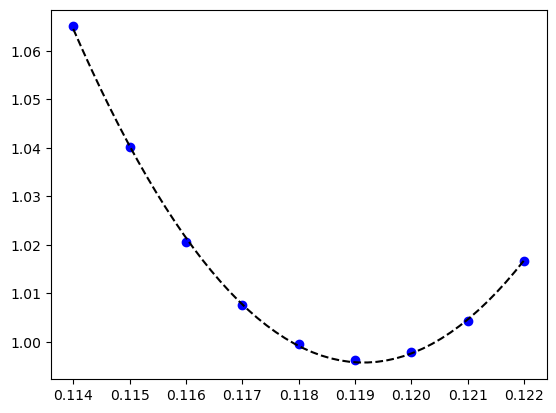

In [11]:
plt.scatter(list(central_chi2_replicas.keys()),list(central_chi2_replicas.values()), color="blue" )
plt.plot(np.linspace(0.114, 0.122), [a*x*x + b*x + c for x in np.linspace(0.114, 0.122)], color="black", linestyle="--")